# 手工构建神经网络

下面的方法没有使用`nn`模块中的任何模组（提供的函数除外）



In [47]:
from typing import override
from pathlib import Path
from pickle import load, dump

import numpy as np
import torch
from torch import Tensor, float32, no_grad
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

## 之前写好的数据集预处理

In [2]:
class MnistDataset(Dataset):
    @override
    def __init__(self, x:torch.Tensor, y:torch.Tensor) -> None:
        super().__init__()
        if len(x) != len(y):
            raise IndexError('len(x) != len(y)')
        self.x = x
        self.y = y
        return
    
    @override
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index], self.y[index]
    
    @override
    def __len__(self) -> int:
        return len(self.x)
    
    
def readDataset(name:str) -> MnistDataset:
    fullImgPath = f'./mnistData/{name}-images.idx3-ubyte'
    fullLabelPath = f'./mnistData/{name}-labels.idx1-ubyte'

    with open(fullImgPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2051:
            raise ValueError(f'head magic number not equal to 2051: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        dataRow = int.from_bytes(f.read(4))
        dataCol = int.from_bytes(f.read(4))
        
        img = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber*dataRow*dataCol,
            offset=0,
            )
    img.shape = (dataNumber,dataRow * dataCol)
    imgTensor = torch.from_numpy(img).type(torch.float32) / 255
        
    with open(fullLabelPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2049:
            raise ValueError(f'head magic number not equal to 2049: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        
        label = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber,
            offset=0,
            )

    labelOnehotTensor = torch.zeros((len(label), 10), dtype=torch.float32)
    for i,j in zip(label, labelOnehotTensor):
        j[i] = 1
    
    return MnistDataset(imgTensor, labelOnehotTensor)

## 导入训练集

如果当前目录下已经有了数据集的缓存`.pickle`文件，那么直接读取该文件，不需要重新解析

如果没有，则对原先的数据集进行解析，然后生成缓存

In [4]:

trainSetPath = Path("./train.pickle")

if trainSetPath.exists():
    with open(trainSetPath, "rb") as f:
        trainSet = load(f)
else:
    trainSet = readDataset("train")
    with open(trainSetPath, "wb") as f:
        dump(trainSet, f)

trainDataLoader = DataLoader(trainSet, 20, True)

## 构建神经网络模型

这个神经网络一共有4层全连接层，前三层使用`ReLU`作为激活函数，最后一层直接输出

由于没有使用优化器，这里优化相关代码直接写在模块的`optim`方法里，导数清理在`zero_grad`方法里

> 这个`__call__`方法是模仿`nn.module`，其实没什么特殊用处，换成普通方法也一样

In [30]:

class ModelWithoutNN:
    def __init__(self) -> None:
        self.fc1 = torch.rand((28*28, 16), dtype=float32)
        self.fc1_bias = torch.rand((1, 16), dtype=float32)
        self.fc1.requires_grad = True
        self.fc1_bias.requires_grad = True

        self.fc2 = torch.rand((16,16), dtype=float32)
        self.fc2_bias = torch.rand((1, 16), dtype=float32)
        self.fc2.requires_grad = True
        self.fc2_bias.requires_grad = True

        self.fc3 = torch.rand((16,10), dtype=float32)
        self.fc3_bias = torch.rand((1, 10), dtype=float32)
        self.fc3.requires_grad = True
        self.fc3_bias.requires_grad = True
        return
    
    def __call__(self, x:Tensor) -> Tensor:
        x = torch.relu(x @ self.fc1 + self.fc1_bias)
        x = torch.relu(x @ self.fc2 + self.fc2_bias)
        x = x @ self.fc3 + self.fc3_bias
        return x
    
    def zero_grad(self) -> None:
        self.fc1.grad = None
        self.fc2.grad = None
        self.fc3.grad = None
        self.fc1_bias.grad = None
        self.fc2_bias.grad = None
        self.fc3_bias.grad = None
        return
    
    def optim(self, lr:float) -> None:
        with no_grad():
            # if self.fc1.grad.max() < 1e-8 \
            #     or self.fc2.grad.max() < 1e-8 \
            #     or self.fc3.grad.max() < 1e-8 \
            #     or self.fc1_bias.grad.max() < 1e-8 \
            #     or self.fc2_bias.grad.max() < 1e-8 \
            #     or self.fc3_bias.grad.max() < 1e-8 :
            #     raise FloatingPointError('梯度消失')
            self.fc1 -= self.fc1.grad * lr
            self.fc2 -= self.fc2.grad * lr
            self.fc3 -= self.fc3.grad * lr
            self.fc1_bias -= self.fc1_bias.grad * lr
            self.fc2_bias -= self.fc2_bias.grad * lr
            self.fc3_bias -= self.fc3_bias.grad * lr
        return


## 借用一下交叉熵损失函数

In [7]:
criterion = torch.nn.functional.cross_entropy

## 开始训练

如果当前目录下没有上一次训练的模型的数据，则随机初始化一个模型

如果已经有了一个模型，那么直接导入模型，继续训练

In [44]:
modelFile = Path('./modelWithoutNN.pickle')

if modelFile.exists():
    with open(modelFile, 'rb') as f:
        model = load(f)
else:
    model = ModelWithoutNN()

lr = 0.001

spoch = 10
for _ in range(spoch):
    for i, data in enumerate(trainDataLoader):
        input:Tensor = data[0]
        model.zero_grad()
        output = model(input)
        loss = criterion(output, data[1])
        loss.backward()
        model.optim(lr)
        pass
        if (i+1) % 100 == 0:
            print(f'loop[{i}]')
            print(loss)
            lr *= 0.8
            print(f'output:{output.T}')
            # print(f'target:{data[1]}')

with open(modelFile, 'wb') as f:
    dump(model, f)

loop[99]
tensor(2.0587, grad_fn=<DivBackward1>)
output:tensor([[26.0225,  9.9120, 19.1164, 13.2144,  8.8476, 15.3219, 12.5534, 23.8644,
         26.8732, 13.7162, 15.1300, 10.2339, 18.1894, 18.5039, 10.2169, 13.7785,
         25.2075, 10.4667, 15.4605, 15.8176],
        [16.1481,  9.3609, 16.4233, 11.3240,  7.7134, 14.1489, 13.2293, 14.5656,
         18.5144, 14.8857, 10.0855, 10.7610, 11.8110, 15.3552,  8.5062, 11.7191,
         19.5105, 11.0565, 10.6314, 10.0309],
        [16.8473, 11.4722, 15.8345, 14.6454,  9.2513, 16.0776, 12.7340, 16.2067,
         19.0808, 16.4601, 10.5083, 12.2558, 14.1780, 15.2127, 11.2164, 13.2703,
         18.7974, 12.6910, 10.9896, 10.0974],
        [24.7538, 10.8075, 19.3156, 13.5624,  9.5470, 16.4689, 14.4247, 22.2739,
         26.5510, 15.5527, 14.2191, 12.1519, 16.6897, 19.3181, 11.2281, 15.9225,
         25.1885, 12.2607, 15.4701, 15.3381],
        [20.7473, 12.3025, 15.2215, 16.7619,  8.0245, 14.2879, 13.4878, 18.4437,
         21.6167, 15.6479, 13.48

## 这里对模型进行测试

使用其余的10k数据进行测试

正确率只有50%多点，但是我把前几个图像和预测打印出来，发现其实错的情有可原，人眼都不一定能选对

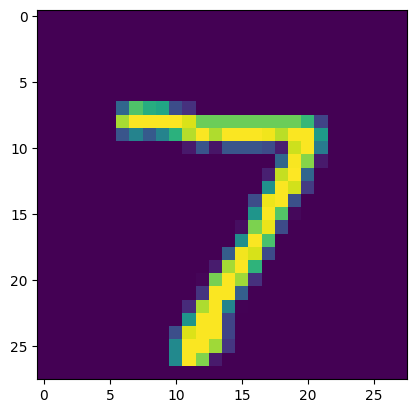

Target: 7
Predict: 7
tensor([True])
--------------------


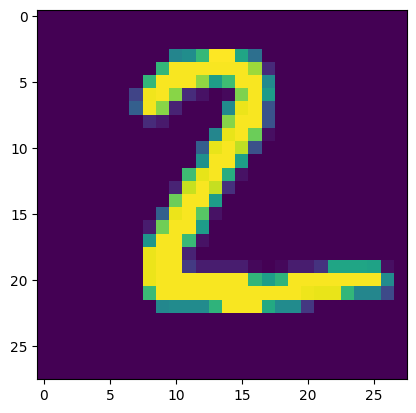

Target: 2
Predict: 8
tensor([False])
--------------------


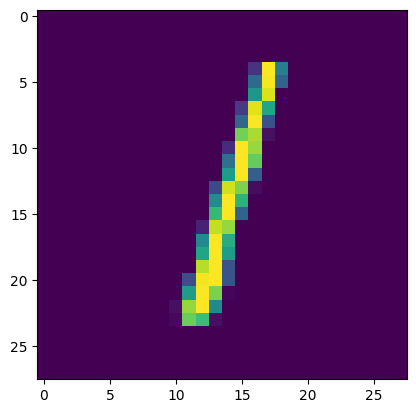

Target: 1
Predict: 1
tensor([True])
--------------------


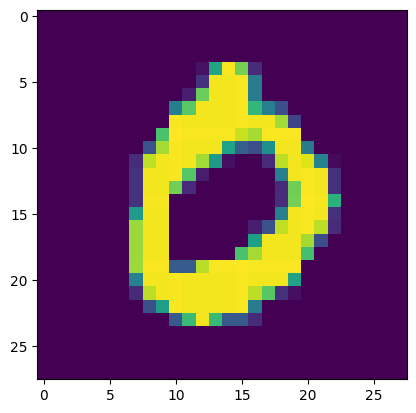

Target: 0
Predict: 0
tensor([True])
--------------------


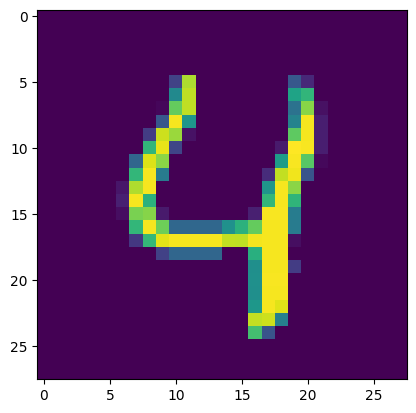

Target: 4
Predict: 6
tensor([False])
--------------------


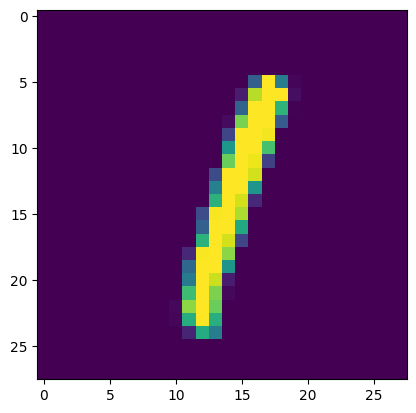

Target: 1
Predict: 1
tensor([True])
--------------------


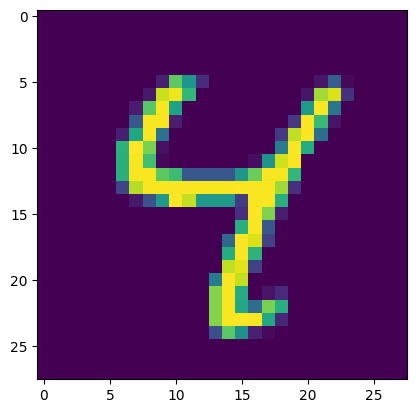

Target: 4
Predict: 9
tensor([False])
--------------------


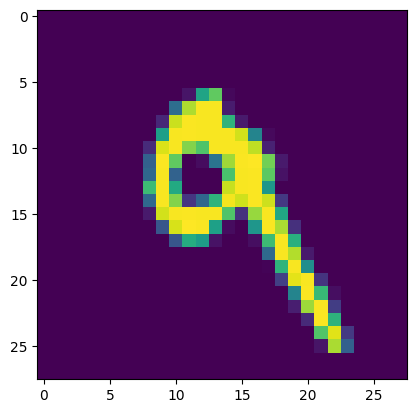

Target: 9
Predict: 1
tensor([False])
--------------------


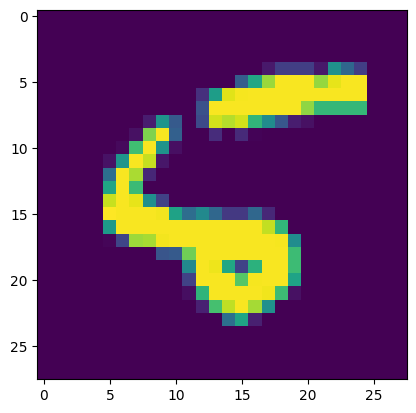

Target: 5
Predict: 7
tensor([False])
--------------------


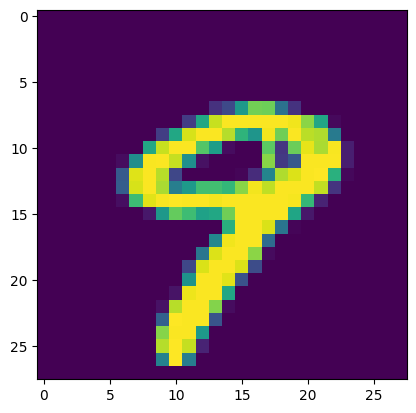

Target: 9
Predict: 7
tensor([False])
--------------------
correction=55.64%


In [51]:
testDataset = readDataset('t10k')
testDataLoader = DataLoader(testDataset, 1, False)

correctCount = 0
showCount = 0
for data in testDataLoader:
    output = model(data[0])
    correction: torch.Tensor = output.argmax(1) == data[1].argmax(1)
    correctCount += int(correction.sum(dtype=torch.int32))
    if showCount < 10:
        showCount += 1
        plt.imshow(data[0].reshape((28,28)))
        plt.show()
        print(f'Target: {data[1].argmax()}')
        print(f'Predict: {output.argmax()}')
        print(correction)
        print('-'*20)


print(f'correction={correctCount / 100}%')